# Imaging biomarker extraction
## Dave Cash and Maria Tziraki
### Health and Bioscience Ideas
#### Team Coders Event: Disease Progression Modelling



## Objectives
After completing this notebook, you will be able to:
* Understand how to open and interrogate meddical imaging data
* Run basic image processing tasks like image registration and segmentation
* Extract measurements of brain volumes and amyloid burden.


## Choosing software
* There are many imaging analysis software packges available that you can use to obtain these measurements:
  * Freesurfer (add link)
  * SPM (add link)
  * ANTs (add link)- this is what we ill be using for the purpose of this notebook. 
* The exact decision of what software and pipeline to use for your research will depend on what works best for your data and application.

In [1]:
%%capture --no-display
import os
import nibabel as nb
import numpy as np
from niwidgets import NiftiWidget
import pandas as pd
import ants

## Imaging formats
There are lots of different imaging formats around, but we will focus on two of the most common:
* [_Digital Image and COmmunication in Medicine_ (DICOM)](https://www.dicomstandard.org/current): the official medical imaging standard used in hosptials and the format most frequently gnerated by scanners
* [_Neuroimaging InFormatics Technology Initiative_(NIFTI)](https://nifti.nimh.nih.gov/nifti-1): a common format that many neuroimaging software packages use, as it tends to be simpler to work with than DICOM.   


## Imaging data structure
Regardless of the file format used, imaging data usually consists of two parts:
* _metadata_: describes key aspects of the image (e.g. size, shape, acquisition, patient information)
* _pixel/voxel data_: The actual data of the image is stored as structured grid representing a flat sheet (2D) of _pixels_ (picture elements) or a cube  (3D) of _voxels_ (volume elements) Each pixel/voxel 

### Voxel data
There are one or more numerical values associated with each pixel/voxel. These values could represent many different quantitites:
* Scalar (single numeric value): intensity, binary mask, anatomical label
* Vector/Array/Tensor (multiple numeric values): RGB colour, velocity/direction, time series

### Opening an image
Data is stored in (put in tree structure)

In [3]:
data_root="/Users/davecash/Data/IDEAS/TeamCoder_EBM/bids"
subject_root = os.path.join(data_root,"sub-011-S-4906","anat",
                            "sub-011-S-4906_desc-t1.nii.gz")
#This is the command that loads the image in
t1_img = nb.load(t1_img_name)

### Essential information
* How many voxels in each direction
* What units of time and distance are used in the imaget
* How big are the voxels

In [4]:
print(f"Dimensons {t1_img.shape}")
print(f"Distance and Time Units: {t1_img.header.get_xyzt_units()}")
print(f"Voxel spacing: {t1_img.header.get_zooms()}")

Dimensons (176, 240, 256)
Distance and Time Units: ('mm', 'sec')
Voxel spacing: (1.1999999, 1.0, 1.0)


## Getting the voxel data
Imaging data tends to be large, so in order to save space, we only load the data when we want to work with it. This is done usning the `get_fdata()` command and soring it in the object `t1_img_data`

In [4]:
t1_img_data = t1_img.get_fdata()

Let's look at one voxel and its intensity. Voxel locations are typically referred to as *i* (Columns), *j* (Rows), and *k* (Slices). Feel free to change location and see how the number changes.

In [6]:
test_voxel = (100,100,80)
print(f"Intensity at voxel {t1_img_data[test_voxel]}")

Intensity at voxel 345.0


## Python is zero-based!!!
Based on dimensions above:
* Number of columns goes from 0 to 175, **not** 1 to 176
* Number of rows goes from 0 to 239, **not** 1 to 240
* Number of slices goes from 0 to 255, **not** 1 to 256

In [8]:
bad_voxel=(1,1,256)
print(t1_img_data[bad_voxel])

IndexError: index 256 is out of bounds for axis 2 with size 256

## Intensity Range

In [9]:
# Get the minimum and maximum
img_min = t1_img_data.min()
img_max = t1_img_data.max()
print(f"Minimum: {img_min}")
print(f"Maximum: {img_max}")

Minimum: 0.0
Maximum: 952.0


## From voxels to the real world
* Voxel space _(i,j,k)_: just position in the grid, no information about its physical location and size
* World space: _(x,y,z)_: location within some real world coordinate system (defined by scanner, neuroanatomical atlas, sterotactic frame)
* The scanner coordinate system often defined as:
  * X axis: Left to Right
  * Y axis: Anterior to Posterior
  * Z axis: Superior to Inferior
![Coordinate Systmes](./Coordinate_sytems.png)
Credit [Slicer](https://www.slicer.org/wiki/Coordinate_systems) 

## Transformation
The transformation is the mapping that allows converting from voxel location to real worls space and back

In [11]:
np.set_printoptions(suppress=True)
print(t1_img.affine)

[[   1.20000458    0.            0.         -103.64485931]
 [   0.            1.            0.         -102.7288208 ]
 [   0.            0.            1.         -152.76271057]
 [   0.            0.            0.            1.        ]]


The output shows the affine transformation which is represented as a four by four matrix. The first 3 rows and columns represent how we *rotate* and *scale* the image voxel to get it into real worlsd space. Here all the numbers off the main diagonal are 0, indicating that there is no rotation, so the image is in an orientation that is aligned with the cardinal axes of the scanner in the real world as shown in the figure above. That means that the rows of voxels go from left to right in the real world and the columns go from the patients front to the patients back, and finally the slices go from the top of the head down towards the neck. As we saw in a previous cell, we know the dimensions of each voxel, so as we move one voxel over in the X direction, we are moving 1.2mm in real world space, and in the other directions we are moving 1.0 mm in real world space. 

The first three numbers in the final column that are all quite large represent the *translation* or shift we need to move the voxel into real-world space. The bottom row is always 0,0,0,1 and is used to make it easier to map one or thousands of points in one single matrix operation. 

This process can easily be _inverted_ so that we can provide the real world coordinates and get the corresponding voxel location back. This is important for when we want to know what the corresponding voxel intensity is when comparing two images. 

In [14]:
# Converting from voxel location to real world coordinates
# Ignore the fourth values, they are just dummy values for convenience
voxel_loc = (100,100,100,1)
real_world = t1_img.affine.dot(voxel_loc)
np.set_printoptions(precision=2)
print(f"Voxel location: {voxel_loc}")
print(f"Real World coordinates: {real_world}")

Voxel location: (100, 100, 100, 1)
Real World coordinates: [ 16.36  -2.73 -52.76   1.  ]


So this means that the voxel (100,100,100) represents physical space (16.4 mm. -2.7 mm, -52.8 mm). When we have different kinds of images acquired in the scanning session or in other scanning sessions, then may have different orientations or different voxel sizes, then it makes it easier to compare and overlay the images together. We will see a bit more abotu that when we discuss registration. 

## Let's look at an image!!!

In [15]:
%%capture --no-display
niwidget = NiftiWidget(t1_img_name)
niwidget.nifti_plotter()

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=87, continuous_update=False, description='x', max=175), IntSlider(value=…

# Image Processing
We will go through some common approaches:
* Bias Correction
* Image Registration
* Brain Extraction
* Parcellation
* Extracting regional values.

## Bias correction
* Slight variations in magnetic field result in gentle low frequency variations in intensity, often called a _bias field_
* These differences can cause issues for subsequent processing routines
* Many routines are available to correct this. We will use a populat one called [N3](https://www.nitrc.org/docman/view.php/6/880/sled.pdf).

In [16]:
# Load in the image
t1_img = ants.image_read(t1_img_name)

#Peform the N3 bias correcction
t1_n3 = ants.n3_bias_field_correction(t1_img)

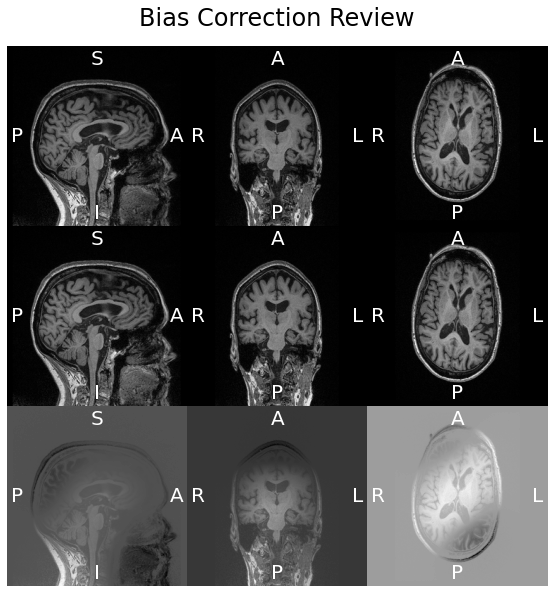

In [18]:
t1_diff = t1_img - t1_n3
ants.plot_ortho_stack(images = [t1_img,t1_n3,t1_diff],
                      title="Bias Correction Review")

## Image registration
Identify the mathematical mapping that aligns the anatomy from one image to another. This has many uses:
* Aligning an image to a standard space to get it in a consistent orientation
* Aligning two different modalities to use complimentary information
* Aligning two timepoints from the same subject to evaluate change over time
* Transferring information from one image to another

## Standard space image - [MNI152](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases) 


In [19]:
atlasdir = os.path.join(data_root,"atlas")
# Load MNI image
mni_img_file = os.path.join(atlasdir,"MNI152_T1_1mm.nii.gz")
mni_img = ants.image_read(mni_img_file)
# Load MNI mask
mni_mask_file = os.path.join(atlasdir,"MNI152_T1_1mm_brain_mask_dil.nii.gz")
mni_mask = ants.image_read(mni_mask_file)

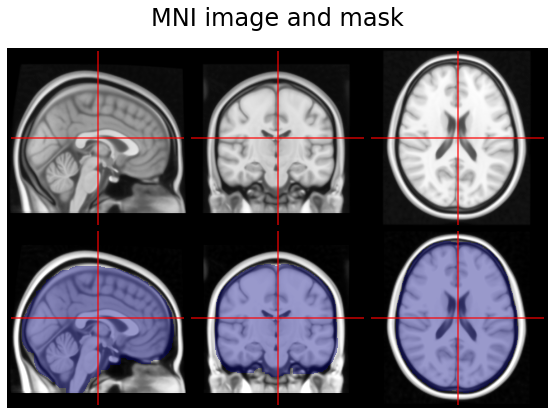

In [33]:
ants.plot_ortho_double(image=mni_img, image2=mni_img,
                       overlay=mni_mask, overlay2=mni_mask,overlay_cmap2="Reds_r",
                       overlay_alpha=0.0, overlay_alpha2=0.4,title="MNI image and mask",title_dy=0.25)

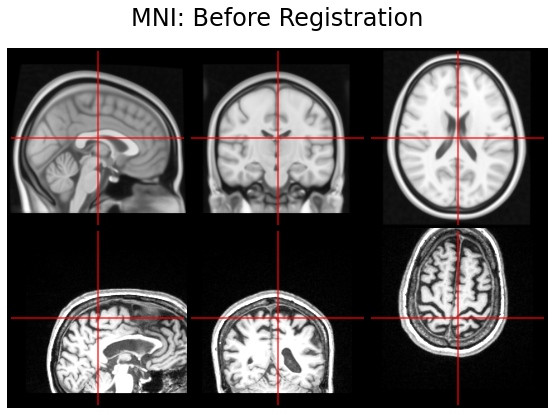

In [37]:
ants.plot_ortho_double(image=mni_img,image2=t1_n3,title="Before Registration",title_dy=0.25)


## Initialise transformation

In [39]:
# Find initial guess
init_tx_file = ants.affine_initializer(fixed_image = mni_img, moving_image = t1_n3, mask = mni_mask)
init_tx = ants.read_transform(init_tx_file)
# Transform T1 with initial guess
t1_mni_init = ants.apply_transforms(fixed = mni_img, moving = t1_n3,transformlist=init_tx_file)


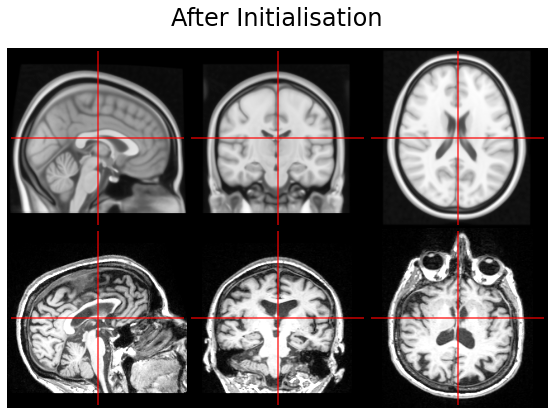

In [40]:
ants.plot_ortho_double(image=mni_img,image2=t1_mni_init,title="After Initialisation",title_dy=0.25)

## Affine Registration

In [41]:
# Using initial guess, run registration
affine = ants.registration(fixed = mni_img, moving = t1_n3,
                           mask = mni_mask,
                           type_of_transform = "Affine", 
                           initial_transform = init_tx_file)

This output is somewhat cryptic. From the [ANTSpy documentation](https://antspy.readthedocs.io/en/latest/index.html), this output is a dictionary that holds four elements:
* _warpedmovout_: Moving image warped to space of fixed image. 
* _warpedfixout_: Fixed image warped to space of moving image. 
* _fwdtransforms_: Transforms to move from moving to fixed image. 
* _invtransforms_: Transforms to move from fixed to moving image.

To see how the registration has performed, we are going to look at the fixed image (the MNI atalas) and the moving image transfored into the fixed space (warpedmovout).

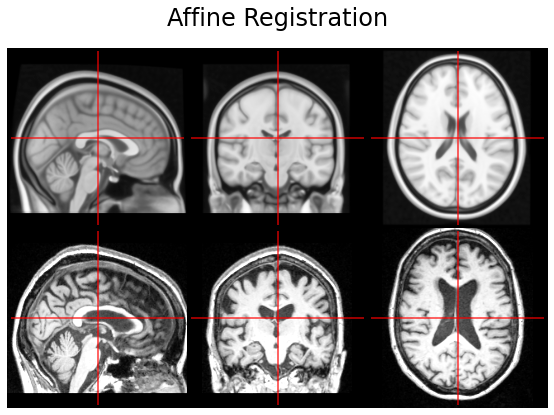

In [42]:
ants.plot_ortho_double(image=mni_img,image2=affine['warpedmovout'],title="Affine Registration",title_dy=0.25)

## Brain extraction (or skull stripping)
* Many image processing steps require removal of non-brain structures (neck, eyes, skull, dura, eta)
* There are many different ways to do this, one simple way is to _transfer_ information from the atlas to your image using the affine registration. 

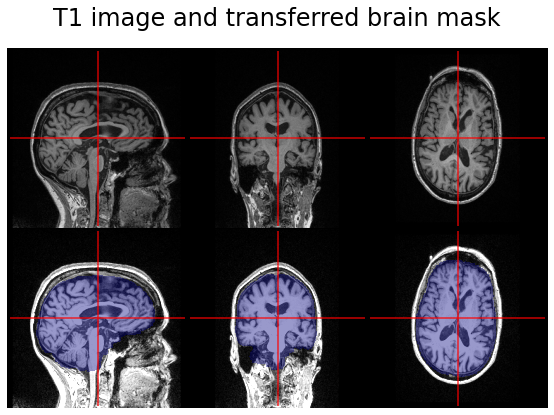

In [44]:
# Use the affine registration to transfer the mask to our image
# We are going the opposite direction from the registration, which is why whichtoinver is set to True
t1_mask = ants.apply_transforms(fixed = t1_n3, moving = mni_mask, interpolator="nearestNeighbor",
                                transformlist=affine['fwdtransforms'],whichtoinvert=[True])
ants.plot_ortho_double(image=t1_n3, image2=t1_n3, scale=True, scale2=True, overlay=t1_mask, overlay2=t1_mask,
                       overlay_alpha=0.0, overlay_alpha2=0.4,title="T1 image and transferred brain mask",title_dy=0.25)

## Mask cleanup

In [46]:
# The utility get_mask can clean up the additional bits outside the brain
t1_brain = ants.mask_image(t1_n3,t1_mask)
t1_mask_cleaned = ants.get_mask(t1_brain,cleanup=3)
t1_brain_cleaned = ants.mask_image(t1_n3,t1_mask_cleaned)

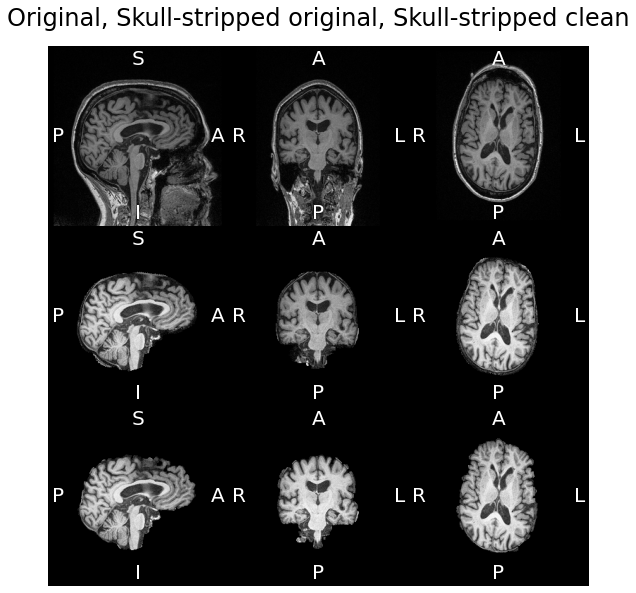

In [48]:
ants.plot_ortho_stack([t1_n3,t1_brain,t1_brain_cleaned],title="Original, Skull-stripped original, Skull-stripped clean")

If you compare the second row and the third row, you can see an additional bit of the connective tissue at the top and front of the brain has been removed.

## Tissue segmentation
At each voxel, we divide the brain up into three primary tissue types: 
1. grey matter (GM),
2. white matter (WM), and
3. cerebrospinal fluid (CSF)

For each voxel, we obtain the probbilities that it contains each tissue type and the most likely tissue.

In [49]:
tissue_seg = ants.atropos(a=t1_n3,x=t1_mask_cleaned,m="[0.3,1x1x1]", i='Kmeans[3]')

The resulting images provide a binary image (second row) of the most likely label (1 for CSF, 2 for GM, 3 for WM), as well as probablistic maps (bottom three rows) of how much of each tissue (a value between 0.0 and 1.0) is contained within each voxel.

We have saved the binary images so that you can look at them in fsleyes, but looking at the probability maps (shown below the segmentation) is also helpful in some cases as well. 

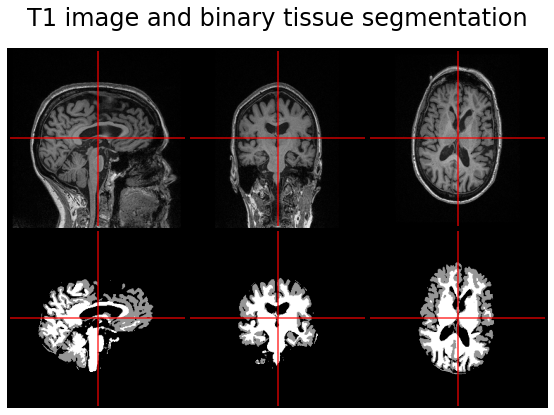

In [52]:
ants.plot_ortho_double(image=t1_n3, image2=tissue_seg['segmentation'],
                       title="T1 image and binary tissue segmentation", title_dy=0.25)

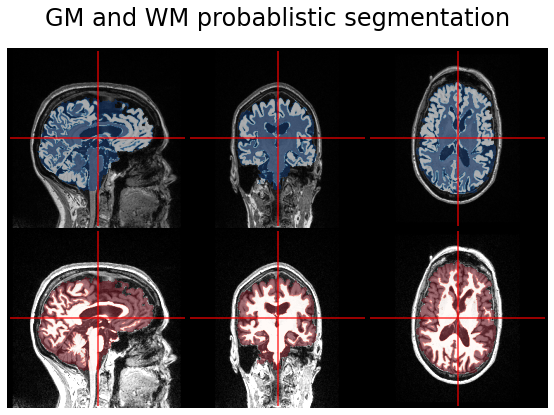

In [57]:
ants.plot_ortho_double(image = t1_n3,image2=t1_n3,
                       overlay=tissue_seg['probabilityimages'][1], overlay_alpha=0.5, overlay_cmap='Blues_r',
                       overlay2=tissue_seg['probabilityimages'][2], overlay_alpha2=0.5,overlay_cmap2='Reds_r',
                       title="GM (red) and WM (blue) probablistic segmentation",title_dy=0.25)


## Extracting statistics from segmentation

In [58]:
tissue_stats = ants.label_stats(t1_n3,tissue_seg['segmentation'])
print(tissue_stats)

   LabelValue        Mean         Min         Max     Variance      Count  \
3         0.0   45.446507    0.000000  763.698242  8478.516362  9586503.0   
0         1.0   81.280816    0.000000  515.789612   918.073146   350432.0   
1         2.0  186.331472   84.513969  554.854614   915.474068   478405.0   
2         3.0  264.410317  165.687088  661.430847   819.631979   398100.0   

         Volume          Mass         x          y          z    t  
3  1.150380e+07  0.000000e+00  0.000000   0.000000   0.000000  0.0  
0  4.205184e+05  2.848340e+07 -3.136276 -11.010318 -25.439895  0.0  
1  5.740859e+05  8.914191e+07 -2.317012 -10.927011 -30.354117  0.0  
2  4.777200e+05  1.052617e+08 -2.907442  -4.847868 -27.829993  0.0  


## Brain parcellation
* Similar to skull stripping or tissue segmentation, but here we are assgining labels of anatomical strutures (e.g. hippocampus, prefrontal gyrus, inferior temporal lobe, etc.) to each voxel. 
* There are many packages out there to do this.
* We will show a method simiilar to skull stripping using the [Automated Anatomical Labelling (AAL) atlas](https://www.gin.cnrs.fr/en/tools/aal/) 

In [59]:
# Determine template, rigid + SYN and then transfer labels over. 
aal_template_file = os.path.join(atlasdir,"AAL3v1_1mm.nii.gz")
aal_template = ants.image_read(aal_template_file).astype("uint32")
aal_img_file = os.path.join(atlasdir,"single_subj_T1.nii")
aal_img = ants.image_read(aal_img_file)

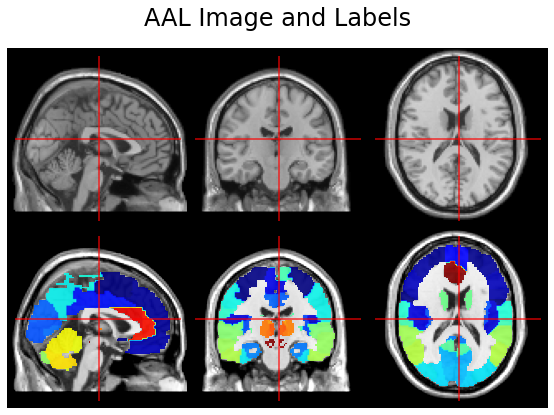

In [60]:
ants.plot_ortho_double(image=aal_img,image2=aal_img, scale=True,scale2=True,overlay=aal_template,overlay2=aal_template,
                      overlay_alpha=0.0,title="AAL Image and Labels",title_dy=0.25)

## Deformable Registration
To get a closer match between our image and AAL, we will do a defomrable registration, which allows local areas to be warped to match the images better. 

In [61]:
# Do an affine initialisation
t1_mask_dil = ants.iMath(t1_mask_cleaned,'MD',2)
aal_affine_init_file = ants.affine_initializer(fixed_image = t1_n3,moving_image = aal_img)

# Perform deformable registration
syn_aal = ants.registration(fixed=t1_n3,moving=aal_img,mask=t1_mask_dil,
                            type_of_transform="SyN",initial_transform=aal_affine_init_file,
                            reg_iterations=(60,30,15))

When we look at the images, they appear to be reasonably well aligned. The venticles are a good area to check as they are typically much larger in older indiiduals and would hae been expanded to match our image. You may also notice the wavy bits in the bright fat regions near the skull in the top of warped tempalte. That is likely because we have told the algorithm to focus only on the brain and not the surrounding areas so these regions do not have to fit very well for the registration to achieve a good alignment. 

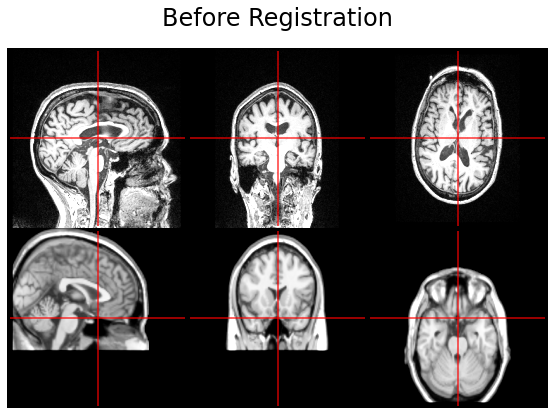

In [73]:
ants.plot_ortho_double(image=t1_n3, image2=aal_img, scale=True,scale2=True,
                       title="Before Registration",title_dy=0.25)

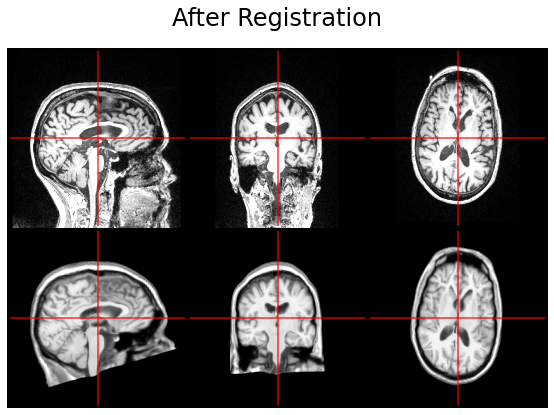

In [74]:
ants.plot_ortho_double(image=t1_n3, image2=syn_aal['warpedmovout'], scale=True,scale2=True,
                       title="After Registration",title_dy=0.25)


The next step is to use the results from the registration to warp the labels into our image. We are only using one subject to do this, where specific variations in anatomy between your source of the labels and the image you want to label. In fact, many groups now use an approach that consists of a _template library_, which contains tens to hundreds of labelled images from individuals with different anatomy and conditions. For each image in the template library, they repeat this process of transferring the labels to the new image using non-rigid registration. This results in the same number of candidate labellings as there are images in the template library. The final step is to resolve differences between the candidate abellins to build one consensus labelling, a step known as _label fusion_. The overall process is often called _multi atlas label fusion_.


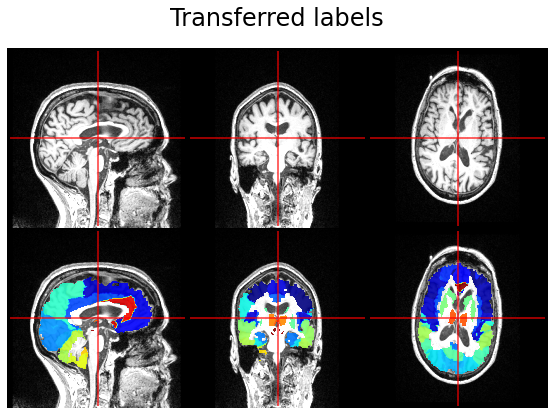

In [72]:
# Transfer anatomical labels from AAL to our image
t1_aal_label = ants.apply_transforms(fixed = t1_n3, moving = aal_template,
                                     transformlist=syn_aal['fwdtransforms'],interpolator="genericLabel")
ants.plot_ortho_double(image=t1_n3,image2=t1_n3,overlay=t1_aal_label,overlay2=t1_aal_label,
                       scale=True,scale2=True,
                      overlay_alpha=0.0,title="Transferred labels",title_dy=0.25)


In [70]:
# Get statistics
aal_stats = ants.label_stats(t1_n3,t1_aal_label)
# Grab label names
df_aal = pd.read_table(os.path.join(atlasdir,"AAL3v1_1mm.nii.txt"),
names=["LabelName","LabelValue"],delim_whitespace=True)
df_aal = df_aal.set_index("LabelValue")
aal_stats = aal_stats.set_index("LabelValue")
aal_stats = aal_stats.join(df_aal)
aal_stats = aal_stats.set_index("LabelName")
aal_stats = aal_stats[["Volume","Mean","Min","Max","Variance"]]

## Get Label Statistics
With some manipulation (not shown), you can show the labels for each value

In [71]:
print(aal_stats)

                       Volume        Mean         Min         Max     Variance
LabelName                                                                     
NaN              1.187768e+07   49.944681    0.000000  763.698242  9133.227852
Precentral_L     1.885560e+04  190.458254    7.131933  314.845673  4720.098670
Precentral_R     1.880280e+04  177.342238    0.990395  303.026154  5292.631203
Frontal_Sup_2_L  2.270400e+04  173.423227    5.752030  303.576630  3973.795143
Frontal_Sup_2_R  2.342160e+04  167.367160    0.000000  297.719757  4114.773860
...                       ...         ...         ...         ...          ...
Red_N_R          4.668000e+02  289.374862  200.934280  337.609131   507.435718
LC_L             1.200000e+01  241.486488  188.494629  320.277435  1363.922542
LC_R             1.800000e+01  154.586862   62.090233  276.395355  2959.780570
Raphe_D          4.800000e+01  249.690186  143.414246  310.540894  1527.498986
Raphe_M          1.920000e+01  176.791312   63.26615

## Brain parcellation with FreeSurfer
Often a more accurate way to get parcellations of a T1 is by using [Freesurfer](https://surfer.nmr.mgh.harvard.edu/). This command takes 3-6 hours to run on most machines. 

`recon-all -subject 011_S_4906 -i bids/sub-011-S-4906/anat/sub-011-S-4096_desc-t1-adni-preproc.nii.gzz -all -threads 4`
![T1 Nu image](./fs_nu.png)
![T1 with aparc+aseg labels](./fs_aparc_aseg.png)

## Co Registration
* Another way of using registration is to align an anatomical image (t1) with a functional image (PET)
* We will re-align our amyloid PET scan to our MRI, so that we can get amyloid measusments by region as defined by the T1. 

In [108]:
bids_desc = "av45-adni-preproc"
av45_name = os.path.join(subject_root,"pet","sub-" + subject_id + "_desc-" + bids_desc + ".nii.gz")
av45 = ants.image_read(av45_name)


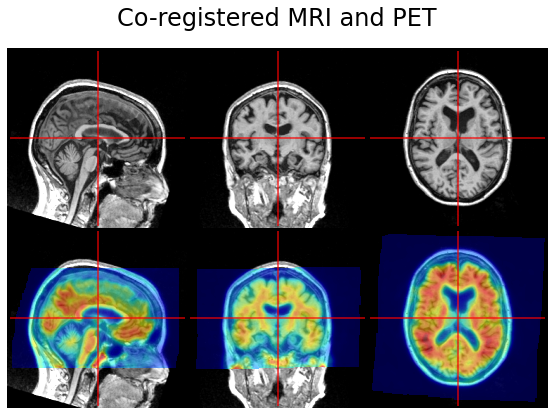

In [113]:
pet_to_mri = ants.registration(fixed = t1_fs_nu,moving=av45,type_of_transform="Rigid")
ants.plot_ortho_double(image=t1_fs_nu,image2=t1_fs_nu,overlay=t1_fs_nu,overlay_alpha=0.0,
                       overlay2=pet_to_mri['warpedmovout'], overlay_alpha2=0.55,
                       scale=True,scale2=True,title="Co-registered MRI and PET", title_dy=0.25)

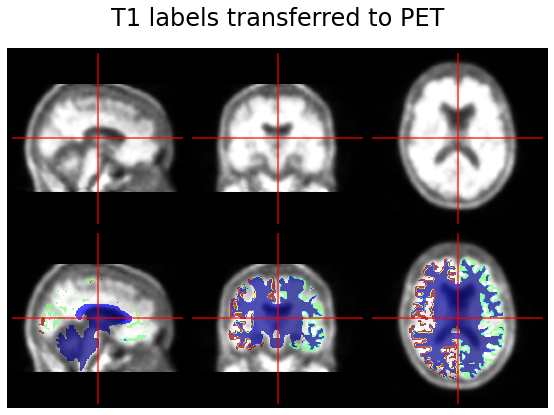

In [115]:
fs_aparc_in_pet = ants.apply_transforms(fixed=av45, moving=t1_fs_aparc,whichtoinvert=[True],
                                        transformlist=pet_to_mri['fwdtransforms'],interpolator="genericLabel")
ants.plot_ortho_double(image=av45,image2=av45,scale=True,scale2=True,
                       overlay=fs_aparc_in_pet, overlay_alpha=0.0,
                       overlay2=fs_aparc_in_pet, overlay_alpha2=0.7,
                       title="T1 labels transferred to PET", title_dy=0.25)

In [118]:
pet_stats = ants.label_stats(av45,fs_aparc_in_pet)
pet_stats["LabelValue"] = pet_stats['LabelValue'].astype("int")
pet_stats = pet_stats.set_index("LabelValue")
df_aparc = pd.read_csv(os.path.join(data_root,"aparc_aseg_roi.csv"),index_col=0)
pet_stats = pet_stats.join(df_aparc)
pet_stats = pet_stats[["LabelName","Volume","Mean","Min","Max","Variance"]]
pet_stats["TotalUptake"] = pet_stats["Volume"] * pet_stats["Mean"]
cerebellum_rows = pet_stats["LabelName"].map(lambda x: "Cerebellum" in x)
ref_volume = pet_stats[cerebellum_rows]['Volume'].sum()
ref_uptake = pet_stats[cerebellum_rows]['TotalUptake'].sum()
mean_ref = ref_uptake / ref_volume
pet_stats["SUVR"] = pet_stats["Mean"] / mean_ref
pet_stats = pet_stats.set_index("LabelName")

The question now is what do these numbers mean? From ADNI's website, it states that they are " intensity normalized using a subject-specific mask so that the average of voxels within the mask is exactly one" But that doesn't make for helpful comparison across subjects. In PET, we tend to normalise on a _reference region_, like the white matter or the cerebellum where there is little specific uptake of the tracer and produce values known as _standardised uptake value ratios_.

We don't need to do any additional image processing for this. This can be done by just re-normalising the values using the new reference region. We just need to determine the mean activity over all of the regionsn that represents the cerebellum (label values 7,8,46,47). Then, we normalise all the values by this mean activity and we have the SUVR. We will save the resulting data so you can take a look at it in Excel.      

## PET statistics
Volumes ($mm^3$) and mean SUVR of region

In [120]:
print(pet_stats[["Volume","SUVR"]])

                                   Volume      SUVR
LabelName                                          
Unknown                       7210708.000  0.224773
Left-Cerebral-White-Matter     217387.125  1.781537
Left-Lateral-Ventricle          31353.750  0.687445
Left-Inf-Lat-Vent                1080.000  1.147559
Left-Cerebellum-White-Matter    11103.750  1.452566
...                                   ...       ...
ctx-rh-supramarginal             9706.500  1.670934
ctx-rh-frontalpole                897.750  1.611692
ctx-rh-temporalpole              2467.125  1.364175
ctx-rh-transversetemporal         816.750  1.723891
ctx-rh-insula                    5956.875  1.556136

[109 rows x 2 columns]
